In [1]:
%matplotlib widget

isdark = False

from rayoptics.environment import *

In [24]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']

osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=16)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=1.5, flds=[0., 0.707, 1.], is_relative=True)
osp['wvls'] = WvlSpec([('F', 0.5), (587.5618, 1.0), ('C', 0.5)], ref_wl=1)

opm.radius_mode = True

sm.gaps[0].thi=1e10

use_schyrle = True
if use_schyrle:
    sm.add_surface([246, 3, 'N-LASF9', 'Schott', 42/2])
    sm.add_surface([1e9, 290+36])
    sm.add_surface([1e9, 3, 'N-LASF9', 'Schott', 16/2])
    sm.add_surface([-30.6, 36+36])
    sm.add_surface([30.6, 3, 'N-LASF9', 'Schott', 16/2])
    sm.add_surface([1e9, 36+36])
    sm.add_surface([1e9, 3, 'N-LASF9', 'Schott', 16/2])
    sm.add_surface([-30.6, 36])
else:
    sm.add_surface([246, 2, 'N-LASF9', 'Schott', 42/2])
    sm.add_surface([1e9, 290+2*36])
    sm.add_surface([1e9, 2, 'N-LASF9', 'Schott', 16])
    sm.add_surface([-30.6, 36+36+36])
    sm.add_surface([30.6, 2, 'N-LASF9', 'Schott', 16])
    sm.add_surface([1e9, 96])
# add a focusing mirror
#sm.add_surface([30.6, 2, 'N-LASF9', 'Schott', 16])
#sm.add_surface([1e9, 36])
#sm.add_surface([-24.456, .975, 'N-SF5,Schott'])
#sm.set_stop()
#sm.add_surface([21.896, 4.822])
#sm.add_surface([86.759, 5.127, 'N-LAK9', 'Schott'])
#sm.add_surface([-30.4942, 41.2365])

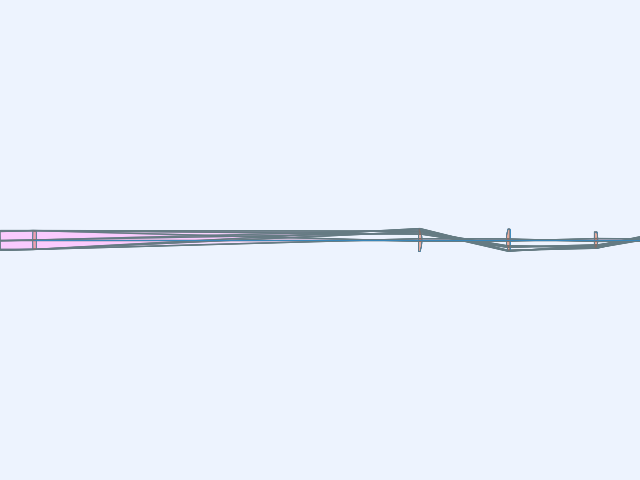

In [25]:
opm.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

In [26]:
pm.first_order_data()

efl                1448
ffl          -1.193e+04
pp1          -1.048e+04
bfl               216.1
ppk                1232
f/#               90.51
m            -1.448e-07
red          -6.905e+06
obj_dist          1e+10
obj_ang             1.5
enp_dist             -0
enp_radius            8
na obj            8e-10
n obj                 1
img_dist          216.1
img_ht            37.92
exp_dist          220.5
exp_radius        0.971
na img        -0.005524
n img                 1
optical invariant       0.2095


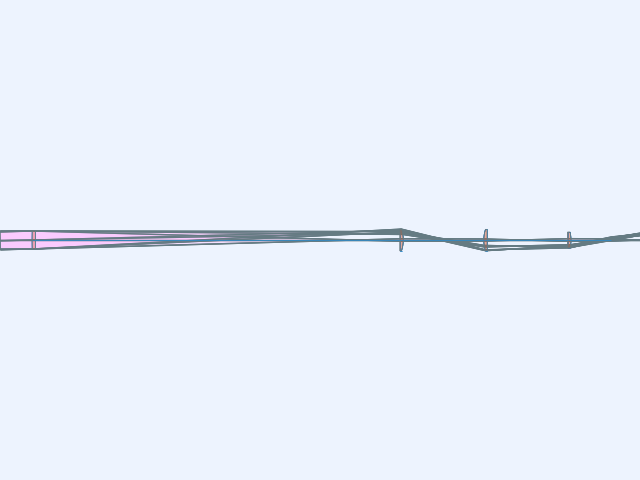

In [27]:
# add a focusing mirror
sm.insert_surface_and_gap()
cur = sm.cur_surface
sm.ifcs[cur] = ThinLens(power=1/30.)
sm.gaps[cur].thi = 30.

opm.update_model()

opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

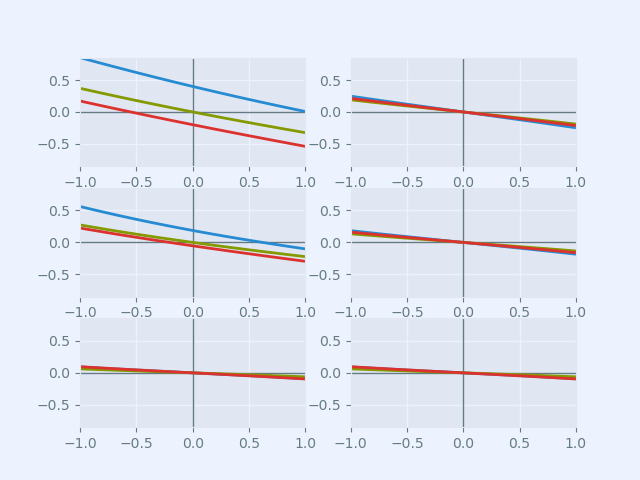

In [28]:
#spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
#                      user_scale_value=0.1, is_dark=isdark).plot()
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray',
                     scale_type=Fit.All_Same).plot()

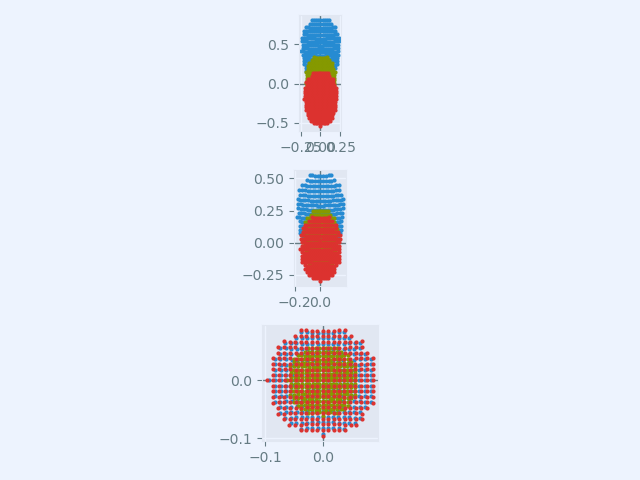

In [29]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

#spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
#                      user_scale_value=0.1, is_dark=isdark).plot()T
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()

In [30]:
# hey it's me from the future, I made these functions

import rayoptics.optical.model_constants as mc

def dump_dist(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[mc.ray]
        dist = foc / ray[-1][mc.d][2]
        defocused_pt = ray[-1][mc.p] + dist*ray[-1][mc.d]
        t_abr = defocused_pt - image_pt
        return np.sqrt(np.sum(t_abr*t_abr))
    
def spot_rms(sm, fld_idx=0):
    return np.sqrt(np.mean(np.square(sm.trace_grid(dump_dist, fld_idx, form='list', append_if_none=False)[0]), axis=1))

def dump_rays(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[mc.ray]
        v = ray[-1][mc.d][0:2] / ray[-1][mc.d][2]
        return [ray[-1][mc.p][0:2] - image_pt[0:2], v]
    
def get_focus(sm, offset=False, weights=np.array([0.25, 0.5, 0.25])):
    offsets = np.linspace(-40, 40, 2000)
    vals, colors = sm.trace_grid(dump_rays, 0, form='list', append_if_none=False)

    rms = np.zeros((offsets.size, len(vals)), dtype=float)

    for i in range(offsets.size):
        for j in range(len(vals)):
            rms[i][j] = np.sqrt(np.mean(np.square(vals[j][:,0]+vals[j][:,1]*offsets[i])))

    if offset:
        return offsets[np.argmin(np.sum(rms*weights, axis=1))]
    else:
        return sm.gaps[-1].thi + offsets[np.argmin(np.sum(rms*weights, axis=1))]

get_focus(sm)

23.655706218096086

(array([0.00418596, 0.01665802, 0.00529431]),
 array([0.25632774, 0.0865608 , 0.10988704]),
 array([0.47439537, 0.14863163, 0.25140339]))

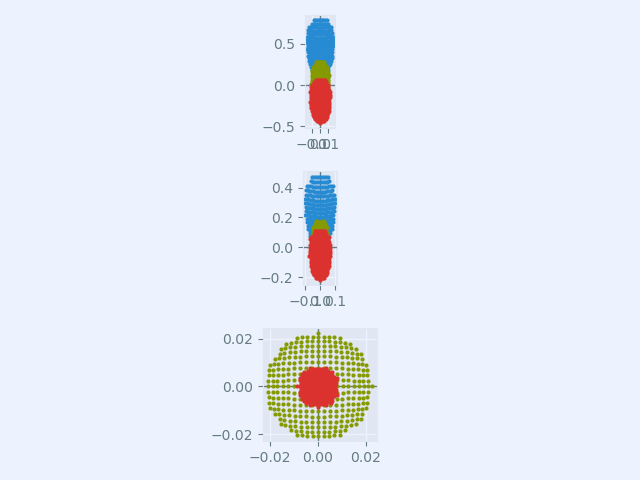

In [31]:
opm.seq_model.gaps[-1].thi = get_focus(sm)
opm.update_model()

#spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
#                      user_scale_value=0.1, is_dark=isdark).plot()T
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
spot_rms(sm, 0), spot_rms(sm, 1), spot_rms(sm, 2)